<a href="https://colab.research.google.com/github/VasiaKoum/Pattern-Recognition-ML/blob/main/support_vector_machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ΕΠ08 Αναγνώριση Προτύπων – Μηχανική Μάθηση<br>
# 3η Εργασία: Support Vector Machines
__ΚΟΥΜΑΡΕΛΑ ΒΑΣΙΛΙΚΗ 1115201600074__<br><br>
Σε αυτή την εργασία καλείστε να διερευνήσετε την επίδοση των support vector machines
(SVMs) στην ταξινόμηση εικόνων, και πιο συγκεκριμένα στην ταξινόμηση εικόνων οι οποίες
απεικονίζουν χειρόγραφα ψηφία.

## Σύνολο Δεδομένων (Dataset)
*Καλείστε να διερευνήσετε την επίδοση των support vector machines στο πρόβλημα της
αναγνώρισης χειρόγραφων ψηφίων. Για το σκοπό αυτό θα χρησιμοποιήσετε το σύνολο
δεδομένων MNIST και υλοποιήσεις αλγορίθμων της βιβλιοθήκης scikit-learn. Το σύνολο
δεδομένων MNIST αποτελείται από 70000 εικόνες χειρόγραφων ψηφίων και, τυπικά,
χωρίζεται σε τρία υποσύνολα: training set (50000 εικόνες), validation set (10000 εικόνες),
test set (10000 εικόνες). Κάθε εικόνα έχει διάσταση 28 x 28 pixels και απεικονίζει ένα
χειρόγραφο ψηφίο*


In [ ]:
from keras.datasets import mnist
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np
# from google.colab import files
import pandas as pd
import joblib
import time

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("Train size set: ", len(x_train), "- Test size set: ", len(x_test))



*Ζητείται να φορτώσετε τα δεδομένα του συνόλου MNIST και να μετατρέψετε κάθε
εικόνα σε μορφή διανύσματος διάστασης 28 x 28 = 784. Στη συνέχεια
κανονικοποιήστε (normalize) τα δεδομένα στο διάστημα [0,1].*
<br>
<br>
Η κανονικοποίηση θα γίνει με τη χρήση του Normalizer από τη βιβλιοθήκη της sklearn. Μετατρέπουμε τα δεδομένα σε 2D (60000, 784) ώστε να τα χρησιμοποιήσουμε χωρίς σφάλμα στο training



In [ ]:
def dim_3dto2d(dataset):
    dataset_reshaped = dataset
    if len(dataset.shape) == 3:
        samples, x1, x2 = dataset.shape
        dataset_reshaped = dataset.reshape((samples,x1*x2))
    return dataset_reshaped

x_train = dim_3dto2d(x_train)
x_test = dim_3dto2d(x_test)

## Ταξινομητής SVM
*Στα SVMs υπάρχουν διάφορες επιλογές που μπορεί να επηρεάσουν την απόδοση
τους σε προβλήματα ταξινόμησης. Παραδείγματα τέτοιων επιλογών αποτελούν ο
τύπος του πυρήνα (kernel) και οι τιμές των διάφορων παραμέτρων. Ζητείται να
εξετάσετε την επίδοση των SVMs για διαφορετικές τιμές παραμέτρων/πυρήνων ώστε
να καθορίσετε το συνδυασμό παραμέτρων/πυρήνων που οδηγούν στη μεγαλύτερη
ακρίβεια ταξινόμησης. Για αυτό το πείραμα να χρησιμοποιήσετε 60000 εικόνες για
εκπαίδευση (training) και 10000 παραδείγματα για δοκιμές (test). Να αναφέρετε τις
τιμές των παραμέτρων, δηλαδή τύπο πυρήνα, τιμές των C και gamma που οδηγούν
στις καλύτερες επιδόσεις τόσο στο σύνολο εκπαίδευσης όσο και στο σύνολο δοκιμής
(test set).*


In [ ]:
def data_subset(dataset, per_train, per_test):
    train_len = int(len(dataset[0])*per_train/100)
    test_len = int(len(dataset[1])*per_test/100)
    x_train = dataset[0][:train_len]
    x_test = dataset[1][:test_len]
    y_train = dataset[2][:train_len]
    y_test = dataset[3][:test_len]
    return x_train, x_test, y_train, y_test

def SVM_classifier(dataset=[], per_train=100, per_test=100, preproc_method="Normalizer", params=[]):
    if preproc_method != "Normalizer" and preproc_method != "Scaler" or not (1 <= per_train <= 100) or not (1 <= per_test <= 100):
        print("Run with: preproc_method = 'Normalizer' or 'Scaler', per_train in [1,100], per_test in [1,100]")
        return
    start = time.time()

    if len(dataset) != 4:
        print("Run with dataset=[x_train, x_test, y_train, y_test]")
        return

    x_train, x_test, y_train, y_test = data_subset(dataset, per_train, per_test)
    print("Training set size: ", len(x_train), " - Test set size: ", len(x_test))

    transformer = Normalizer()
    if preproc_method == "Scaler":
        transformer = StandardScaler()
    pipeline = Pipeline(steps=[('transformer', transformer), ('SVM', SVC())])
    parameters = params
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(pipeline, param_grid=parameters, cv=cv)
    grid.fit(x_train, y_train)
    print("Score = %3.2f" %(grid.score(x_test, y_test)))
    y_pred = grid.predict(x_test)

    exe_time = (time.time() - start)/60
    print("Execution time", exe_time)
    dataset_subset = [x_train, x_test, y_train, y_test, y_pred]
    return grid, dataset_subset

Επιλογή ποσοστού για το training & testing του SVM επί του συνόλου δεδομένων:
$per$_ $train$, $per$_ $test$
<br>
π.χ. $per$_ $train=20$ τότε θα χρησιμοποιηθούν $60000*20/100=12000$

In [ ]:
set_per_train = 100
set_per_test = 100

Θα χρησιμοποιηθούν οι παρακάτω συναρτήσεις (για kernels):<br>
* Linear Function $K(x_i, x_j)=x_i*x_j$
* Polynomial(poly) Function $K(x_i, x_j)=(1+x_i*x_j)^d$
* Gaussian radial basis Function(rbf) Function $K(x_i, x_j)=exp(-\gamma ||x_i-x_j||)^d$
<br><br>
Η παράμετρος gamma $(\gamma)$ χρησιμοποιείται μόνο για την Gaussian radial basis Function.

In [ ]:
dataset_ = [x_train, x_test, y_train, y_test]

# parameters = [ {"SVM__kernel": ["linear", "poly"], "SVM__C": [1, 10, 100, 1000]}, 
#            {"SVM__kernel": ["rbf"], "SVM__C": [1, 10, 100, 1000], "SVM__gamma": [10,1,0.1,0.01]} ]

parameters = [ {"SVM__kernel": ["linear", "poly"], "SVM__C": [0.1, 1, 10, 100]}]

grid, dataset_subset = SVM_classifier(dataset=dataset_, per_train=set_per_train, per_test=set_per_test, params=parameters)
joblib.dump(grid, 'mnist_svm_classifier.pkl')
# files.download('mnist_svm_classifier.pkl')

Training set size:  60000  - Test set size:  10000
Score = 0.99
Execution time 170.43815218210221


['mnist_svm_classifier.pkl']

Θα γίνει εκπαίδευση του SVM classifier και το GridSearchCV θα αποθηκευτεί σε αρχείο pickle

In [ ]:
grid = joblib.load("mnist_svm_classifier.pkl")
print("Best score", grid.best_score_,"with best parameters", grid.best_params_)
df = pd.DataFrame(grid.cv_results_)
if 'param_SVM__gamma' in df.columns:
    df = df[['param_SVM__kernel', 'param_SVM__C', 'param_SVM__gamma', 'mean_test_score', 'mean_fit_time', 'mean_score_time']]
else:
    df = df[['param_SVM__kernel', 'param_SVM__C', 'mean_test_score', 'mean_fit_time', 'mean_score_time']]
df.sort_values(by=['mean_test_score'], ascending=False)

Best score 0.9851666666666666 with best parameters {'SVM__C': 10, 'SVM__kernel': 'poly'}


,param_SVM__kernel,param_SVM__C,mean_test_score,mean_fit_time,mean_score_time
5,poly,10,0.985167,151.403805,57.376795
7,poly,100,0.985167,153.981053,57.455523
3,poly,1,0.984133,153.064651,55.753010
1,poly,0.1,0.970667,263.845512,79.912391
4,linear,10,0.941633,119.636093,52.653587
2,linear,1,0.939917,151.433372,66.311614
6,linear,100,0.933733,154.234085,46.046697
0,linear,0.1,0.927300,306.041010,110.010452


## Εφαρμογή PCA
*Στη συνέχεια, να εφαρμόσετε PCA στα δεδομένα επιλέγοντας 3 διαφορετικές τιμές
για τη διατηρούμενη διακύμανση και για κάθε τιμή διακύμανσης εκτελέστε ξανά τη
μέθοδο SVM χρησιμοποιώντας τις παραμέτρους που οδήγησαν στην καλύτερη
επίδοση στο παραπάνω ερώτημα. Για κάθε εκτέλεση, αναφέρετε τον αριθμό των
συνιστωσών (components) που διατηρούνται καθώς και την ακρίβειας ταξινόμησης.
Επίσης, καταγράψτε τους χρόνους εκτέλεσης κάθε πειράματος και εξαγάγετε
συμπεράσματα σχετικά με μια πιθανή αντιστάθμιση (trade-off) μεταξύ ακρίβειας
ταξινόμησης, μείωσης διαστάσεων και χρόνου εκτέλεσης του αλγορίθμου.*
<br>
<br>
Εάν θέλουμε η **διατηρούμενη διακύμανση** να είναι σε κάποιο συγκεκριμένο ποσοστό, ορίζουμε ως number_comp = %ζητούμενη_διακύμανση, αλλιώς εάν επιθυμούμε συγκεκριμένο αριθμό συνιστωσών θα πρέπει να ισχύει: number_comp>0




In [ ]:
def plot_variance(pca, number_comp):
    cumExplainedVar=np.cumsum(pca.explained_variance_ratio_)
    floor = np.max(cumExplainedVar)
    max_components = np.argwhere((cumExplainedVar >= floor) & (cumExplainedVar < (floor+0.1*floor))).flatten()[0]
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.bar(range(number_comp),pca.explained_variance_ratio_[:number_comp])
    plt.xlabel('Αριθμός Συνιστωσών')
    plt.ylabel('Διατηρούμενη Διακύμανση');

    plt.subplot(1, 2, 2)
    for i in np.arange(0.8,0.9,0.001):
        plt.axhline(y=i, color= "whitesmoke")
    plt.plot(cumExplainedVar)
    plt.plot(max_components,cumExplainedVar[max_components],'ro') 
    plt.xlabel('Αριθμός Συνιστωσών')
    plt.ylabel('Συσσωρευτική Διατηρούμενη Διακύμανση');
    plt.show()

def PCA_nComponents(x_train, x_test, number_comp, grid, plot):
    x_train_pca = PCA(n_components=number_comp, svd_solver='full').fit(x_train)
    x_train_components = x_train_pca.transform(x_train)
    x_test_pca = PCA(n_components=x_train_pca.n_components_, svd_solver='full').fit(x_test)
    x_test_components = x_test_pca.transform(x_test)

    if plot:
        plot_variance(x_train_pca, x_train_pca.n_components_)

    print ("Components = ", x_train_pca.n_components_ ,";\nTotal explained variance = ", round(x_train_pca.explained_variance_ratio_.sum(),5)  )
    dataset_ = [x_train_components, x_test_components, y_train, y_test]

    fix_params = {}
    for key, value in grid.best_params_.items():
        d = {key:[value]}
        fix_params.update(d)

    grid_pca, dataset_subset = SVM_classifier(dataset=dataset_, per_train=set_per_train, per_test=set_per_test, params=fix_params)
    joblib.dump(grid_pca, 'mnist_pca_svm_classifier.pkl')
    # files.download('mnist_pca_svm_classifier.pkl')
    # grid_pca = joblib.load("mnist_svm_classifier.pkl")
    print("Best score", grid_pca.best_score_,"with best parameters", grid_pca.best_params_)
    df = pd.DataFrame(grid_pca.cv_results_)
    if 'param_SVM__gamma' in df.columns:
        df = df[['param_SVM__kernel', 'param_SVM__C', 'param_SVM__gamma', 'mean_test_score', 'mean_fit_time', 'mean_score_time']]
    else:
        df = df[['param_SVM__kernel', 'param_SVM__C', 'mean_test_score', 'mean_fit_time', 'mean_score_time']]
    df.sort_values(by=['mean_test_score'], ascending=False)

Εκτέλεση της PCA_nComponents(δεδομένα εκπαίδευσης, test δεδομένα, αριθμός συνιστωσών, το GridSearchCV της παραπάνω εκπαίδευσης, True ή False για την εκτύπωση γραφήματος). 

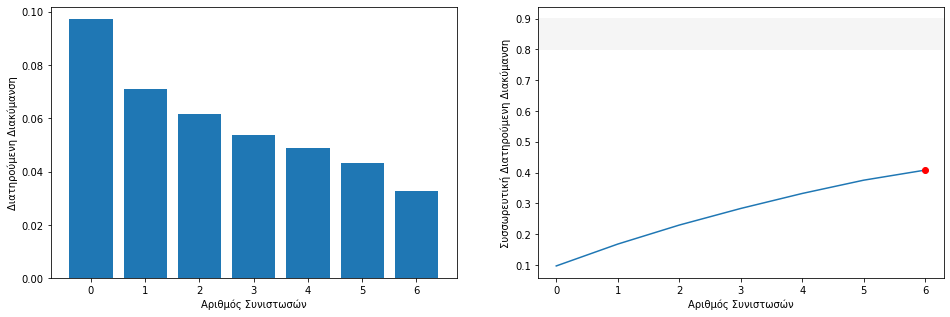

Components =  7 ;
Total explained variance =  0.40812
Training set size:  60000  - Test set size:  10000
Score = 0.22
Execution time 3.4092468778292337
Best score 0.8646166666666666 with best parameters {'SVM__C': 10, 'SVM__kernel': 'poly'}


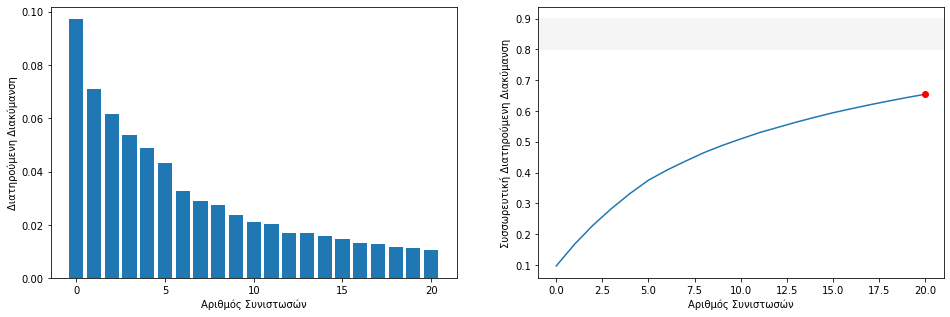

Components =  21 ;
Total explained variance =  0.65424
Training set size:  60000  - Test set size:  10000
Score = 0.13
Execution time 2.68569176197052
Best score 0.9766166666666667 with best parameters {'SVM__C': 10, 'SVM__kernel': 'poly'}


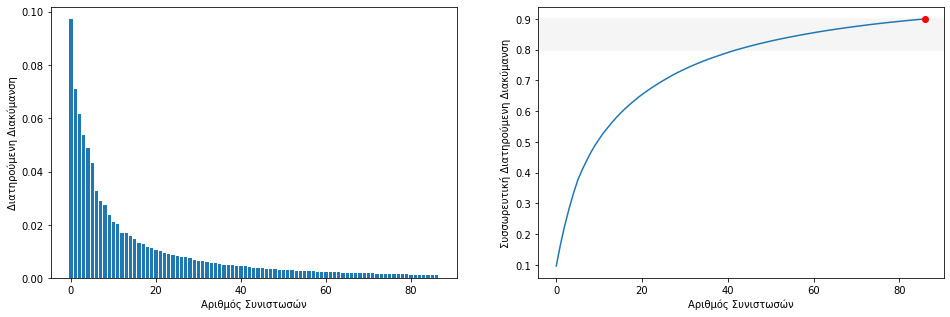

Components =  87 ;
Total explained variance =  0.90011
Training set size:  60000  - Test set size:  10000
Score = 0.13
Execution time 9.064098803202311
Best score 0.9868833333333333 with best parameters {'SVM__C': 10, 'SVM__kernel': 'poly'}


In [ ]:
PCA_nComponents(x_train, x_test, 0.40, grid, True)
PCA_nComponents(x_train, x_test, 0.65, grid, True)
PCA_nComponents(x_train, x_test, 0.90, grid, True)

In [ ]:
from google.colab import drive
import sys
drive.mount('/content/drive')
pkl = "/content/drive/MyDrive/ML/mnist_svm_classifier.pkl"
pkl_pca = "/content/drive/MyDrive/ML/mnist_pca_svm_classifier.pkl"

grid = joblib.load(pkl)
grid_pca = joblib.load(pkl_pca)
print("--------> For Training set size:  12000  - Test set size:  2000 and linear, poly, rbf and C,gamma = 1, 10, 100")
print("Best score", grid.best_score_,"with best parameters", grid.best_params_)
df = pd.DataFrame(grid.cv_results_)
if 'param_SVM__gamma' in df.columns:
    df = df[['param_SVM__kernel', 'param_SVM__C', 'param_SVM__gamma', 'mean_test_score', 'mean_fit_time', 'mean_score_time']]
else:
    df = df[['param_SVM__kernel', 'param_SVM__C', 'mean_test_score', 'mean_fit_time', 'mean_score_time']]
df.sort_values(by=['mean_test_score'], ascending=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--------> For Training set size:  12000  - Test set size:  2000 and linear, poly, rbf and C,gamma = 1, 10, 100
Best score 0.9711666666666667 with best parameters {'SVM__C': 10, 'SVM__kernel': 'poly'}


,param_SVM__kernel,param_SVM__C,param_SVM__gamma,mean_test_score,mean_fit_time,mean_score_time
5,poly,10,NaN,0.971167,10.827205,3.162293
3,poly,1,NaN,0.969500,10.859758,3.085548
13,rbf,10,1,0.964333,9.367451,3.342008
10,rbf,1,1,0.955833,10.070767,3.393352
1,poly,0.1,NaN,0.944667,16.570929,4.075422
12,rbf,10,0.1,0.939833,6.962410,2.870550
2,linear,1,NaN,0.932000,7.347908,2.919110
4,linear,10,NaN,0.928167,5.223567,2.228071
7,rbf,0.1,1,0.919667,21.206935,5.310530
9,rbf,1,0.1,0.917000,14.780004,4.819524


In [ ]:
print("Best score", grid_pca.best_score_,"with best parameters", grid_pca.best_params_)
df = pd.DataFrame(grid_pca.cv_results_)
if 'param_SVM__gamma' in df.columns:
    df = df[['param_SVM__kernel', 'param_SVM__C', 'param_SVM__gamma', 'mean_test_score', 'mean_fit_time', 'mean_score_time']]
else:
    df = df[['param_SVM__kernel', 'param_SVM__C', 'mean_test_score', 'mean_fit_time', 'mean_score_time']]
df.sort_values(by=['mean_test_score'], ascending=False)

Best score 0.9713333333333333 with best parameters {'SVM__C': 10, 'SVM__kernel': 'poly'}


,param_SVM__kernel,param_SVM__C,mean_test_score,mean_fit_time,mean_score_time
0,poly,10,0.971333,2.097583,0.376625


## Συμπεράσματα


*   Για το πρώτο κομμάτι, ο SVM εκπαιδεύτηκε για το 100% του συνόλου δεδομένων με τις εξής παραμέτρους: kernel = linear,poly,rbf(20% του συνόλου δεδομένων) | C = 1, 10, 100 (0.1,1,10 για το 20% του συνόλου δεδομένων) | gamma(μόνο για rbf) = 0.1,1,10. Σύμφωνα με το GridSearchCV, οι παράμετροι με την καλύτερη απόδοση είναι: {'SVM__C': 10, 'SVM__kernel': 'poly'}. Παρατηρούμε πως καλύτερη Kernel Function είναι η poly, το οποίο σημαίνει πως τα δεδομένα ταξινομούνται καλύτερα με πολυωνυμική συνάρτηση. Σχετικά με την υπερπαράμετρο C, η οποία ελέγχει το σφάλμα, όταν επιλέγουμε μικρή τιμή, συνήθως έχουμε χαμηλό σφάλμα, κάτι το οποίο δεν σημαίνει και καλό decision boundary και αντίστοιχα για υψηλό C, έχουμε υψηλό σφάλμα. Για το συγκεκριμένο dataset η ιδανική τιμή για το C είναι το 10. Το $\gamma$ ρυθμίζει την καμπυλότητα του ορίου απόφασης (decision boundary). Έτσι, όταν επιλέγουμε μικρό $\gamma$ έχουμε λιγότερη καμπυλότητα στο decision boundary και όταν επιλέγουμε υψηλό $\gamma$ έχουμε περισσότερη καμπυλότητα. Η τιμή 1 για το $\gamma$ επιτυγχάνει την καλύτερη ακρίβεια, όταν χρησιμοποιούμε την rbf function. Ο χρόνος εκπαίδευσης κυμαίνεται από 151 έως 306 δευτερόλεπτα (μέσος όρος) ανάλογα την επιλογή του kernel και παρατηρούμε πως για μικρό C ο χρόνος είναι μεγαλύτερος.

*   Με την εφαρμογή του PCA και τη μείωση διαστάσεων, παρατηρούμε πως η διατηρούμενη διακύμανση αυξάνεται με περισσότερο ρυθμό για <60 συνιστώσες, ενώ για παραπάνω συνιστώσες μειώνεται ο ρυθμός αύξησης. Για 87 συνιστώσες επιτυγχάνουμε καλύτερο Cross-validated score (of the best_estimator) 0.98 με τις παραμέτρους {'SVM__C': 10, 'SVM__kernel': 'poly'}

## Πηγές
* [Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html)
* [Multiclass Classification with Support Vector Machines (SVM), Dual Problem and Kernel Functions](https://towardsdatascience.com/multiclass-classification-with-support-vector-machines-svm-kernel-trick-kernel-functions-f9d5377d6f02)
* [sklearn.preprocessing.Normalizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html)
* [Explained variance in PCA](https://https://ro-che.info/articles/2017-12-11-pca-explained-variance)


